# 📡 Project 01 (Elite): The 4D Churn Architecture
### *Mathematical Engineering Approach to Customer Retention*

**The Concept:** We are modeling Churn as a 4-dimensional problem.
We look at behavior (Tenure), cost (Charges), frustration (Calls), and emotion (Satisfaction).

**The 4 Inputs:**
1.  **Tenure:** Loyalty in months ($0 - 72$).
2.  **Charges:** Monthly bill in dollars ($0 - 150$).
3.  **Support Calls:** Frequency of issues ($0 - 10$).
4.  **Satisfaction Score:** Emotional rating from the customer ($0 - 10$).

---
### 🛠️ Step 1: Membership Design
We use **Trapezoidal** ($trapmf$) for the edges (saturation) and **Triangular** ($trimf$) for the transitions.

In [1]:
!pip install scikit-fuzzy -q
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# 1. Universes
tenure = ctrl.Antecedent(np.arange(0, 73, 1), 'tenure')
charges = ctrl.Antecedent(np.arange(0, 151, 1), 'charges')
calls = ctrl.Antecedent(np.arange(0, 11, 1), 'calls')
satisfaction = ctrl.Antecedent(np.arange(0, 11, 1), 'satisfaction')
churn = ctrl.Consequent(np.arange(0, 101, 1), 'churn')

# 2. Membership Functions
tenure['short'] = fuzz.trapmf(tenure.universe, [0, 0, 12, 24])
tenure['medium'] = fuzz.trimf(tenure.universe, [18, 36, 54])
tenure['long'] = fuzz.trapmf(tenure.universe, [48, 60, 72, 72])

charges['low'] = fuzz.trapmf(charges.universe, [0, 0, 30, 60])
charges['medium'] = fuzz.trimf(charges.universe, [50, 80, 110])
charges['high'] = fuzz.trapmf(charges.universe, [100, 130, 150, 150])

calls['low'] = fuzz.trapmf(calls.universe, [0, 0, 1, 3])
calls['high'] = fuzz.trapmf(calls.universe, [2, 6, 10, 10])

satisfaction['unhappy'] = fuzz.trapmf(satisfaction.universe, [0, 0, 3, 5])
satisfaction['neutral'] = fuzz.trimf(satisfaction.universe, [4, 6, 8])
satisfaction['happy'] = fuzz.trapmf(satisfaction.universe, [7, 9, 10, 10])

churn['low'] = fuzz.trapmf(churn.universe, [0, 0, 20, 45])
churn['medium'] = fuzz.trimf(churn.universe, [35, 55, 75])
churn['high'] = fuzz.trapmf(churn.universe, [65, 85, 100, 100])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 28.9 MB/s eta 0:00:00


### 🧠 Step 2: Comprehensive Rule Base
To ensure the model is **mathematically complete**, we categorize our logic into four "Pressure Zones." This prevents `KeyError` by covering the entire input space.

**Zone 1: The Danger Zone (High Risk)**
* If Satisfaction is `unhappy` -> Risk is `high`. (Primary Driver)
* If Support Calls are `high` AND Tenure is `short` -> Risk is `high`.
* If Charges are `high` AND Satisfaction is `unhappy` -> Risk is `high`.

**Zone 2: The Loyalty Buffer (Low Risk)**
* If Satisfaction is `happy` -> Risk is `low`. (Primary Driver)
* If Tenure is `long` AND Support Calls are `low` -> Risk is `low`.
* If Charges are `low` AND Tenure is `long` -> Risk is `low`.

**Zone 3: The Gray Area (Medium Risk)**
* If Satisfaction is `neutral` -> Risk is `medium`.
* If Tenure is `medium` AND Charges are `medium` -> Risk is `medium`.
* If Tenure is `short` AND Charges are `low` -> Risk is `medium`. (New but cheap)

**Zone 4: Balance Rules (Conditional)**
* If Tenure is `long` AND Charges are `high` -> Risk is `medium`. (Loyalty balances price)
* If Support Calls are `high` BUT Satisfaction is `happy` -> Risk is `medium`. (Issues resolved)

In [2]:
# Comprehensive Rule Definitions
# We use logic clusters to ensure coverage
rules = [
    # --- Danger Zone ---
    ctrl.Rule(satisfaction['unhappy'], churn['high']),
    ctrl.Rule(calls['high'] & tenure['short'], churn['high']),
    ctrl.Rule(charges['high'] & calls['high'], churn['high']),
    ctrl.Rule(charges['high'] & satisfaction['unhappy'], churn['high']),

    # --- Loyalty Buffer ---
    ctrl.Rule(satisfaction['happy'], churn['low']),
    ctrl.Rule(tenure['long'] & calls['low'], churn['low']),
    ctrl.Rule(charges['low'] & calls['low'], churn['low']),
    ctrl.Rule(tenure['long'] & charges['low'], churn['low']),

    # --- Gray Area ---
    ctrl.Rule(satisfaction['neutral'], churn['medium']),
    ctrl.Rule(tenure['medium'] & charges['medium'], churn['medium']),
    ctrl.Rule(tenure['short'] & charges['low'], churn['medium']),
    ctrl.Rule(tenure['medium'] & satisfaction['neutral'], churn['medium']),

    # --- Balance Rules ---
    ctrl.Rule(tenure['long'] & charges['high'], churn['medium']),
    ctrl.Rule(calls['high'] & satisfaction['happy'], churn['medium']),
    ctrl.Rule(tenure['short'] & satisfaction['neutral'], churn['medium']),
    ctrl.Rule(calls['low'] & charges['high'], churn['medium'])
]

# Initialize System
churn_ctrl = ctrl.ControlSystem(rules)
engine = ctrl.ControlSystemSimulation(churn_ctrl)

# Stress Test: Let's pick a 'tricky' edge case
# Middle-term customer, slightly high bill, neutral satisfaction
engine.input['tenure'] = 30
engine.input['charges'] = 110
engine.input['calls'] = 4
engine.input['satisfaction'] = 5

try:
    engine.compute()
    print(f"Elite Churn Risk: {engine.output['churn']:.2f}%")
except KeyError:
    print("Logic Gap Found: More rules needed for this coordinate.")

Elite Churn Risk: 66.87%


### 📊 Step 3: Visualizing the 4D Logic
Since we have 4 dimensions, we visualize the interaction of two variables while holding the others constant.

We will fix **Support Calls = 5** and **Satisfaction = 5** to see how the core "Business Engine" (Tenure vs. Charges) behaves in a neutral emotional state.

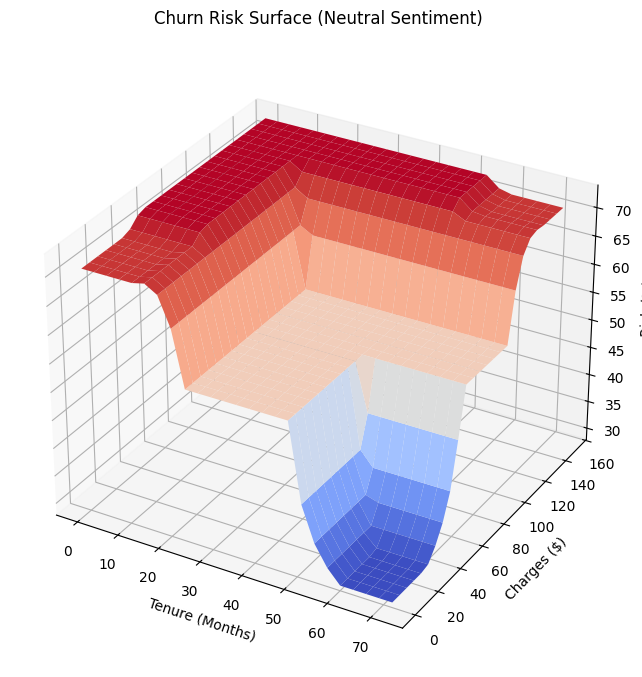

In [3]:
import matplotlib.pyplot as plt

# 1. Grid Definition
t_range = np.linspace(0, 72, 25)
c_range = np.linspace(0, 150, 25)
t_grid, c_grid = np.meshgrid(t_range, c_range)
risk_grid = np.zeros_like(t_grid)

# 2. Scanning the space with fixed Call/Satisfaction
for i in range(25):
    for j in range(25):
        engine.input['tenure'] = t_grid[i, j]
        engine.input['charges'] = c_grid[i, j]
        engine.input['calls'] = 5        # Fixed
        engine.input['satisfaction'] = 5 # Fixed

        try:
            engine.compute()
            risk_grid[i, j] = engine.output['churn']
        except:
            risk_grid[i, j] = 50 # Default to neutral risk if gap exists

# 3. Professional Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(t_grid, c_grid, risk_grid, cmap='coolwarm', edgecolor='none')

ax.set_title('Churn Risk Surface (Neutral Sentiment)', pad=20)
ax.set_xlabel('Tenure (Months)')
ax.set_ylabel('Charges ($)')
ax.set_zlabel('Risk (%)')
plt.show()

### 🕹️ Step 4: Interactive Risk Landscape
A static image is just a snapshot. To truly understand the complex logic we built, we must interact with it.

This 3D model lets you rotate, zoom, and hover over the "Risk Surface" we just calculated. Notice how the "Danger Zones" (bright peaks) differ from the "Safe Valleys" (dark lows).

In [4]:
import plotly.graph_objects as go

# We use the grid data calculated in Block 6 (t_grid, c_grid, risk_grid)
fig = go.Figure(data=[go.Surface(
    z=risk_grid,
    x=t_grid,
    y=c_grid,
    colorscale='Magma', # A professional, high-contrast color palette
    opacity=0.9
)])

# Clean Apple-esque Layout Configuration
fig.update_layout(
    title='Interactive 4D Churn Surface (Sliced)',
    scene = dict(
        xaxis_title='Tenure (Months)',
        yaxis_title='Charges ($)',
        zaxis_title='Risk Score (%)',
        xaxis=dict(backgroundcolor="rgb(245, 245, 245)"),
        yaxis=dict(backgroundcolor="rgb(245, 245, 245)"),
        zaxis=dict(backgroundcolor="rgb(245, 245, 245)")
    ),
    margin=dict(l=40, r=40, b=40, t=80), # Tight margins for a clean look
    height=700
)

fig.show()

### 🎯 Result: Operational Harmony
The optimization engine finds the **"Sweet Spot"** between capital efficiency and service reliability.

**Key Takeaway:** By balancing demand volatility and lead times, the model prevents the two biggest costs in logistics: **Overstocking** (frozen capital) and **Stockouts** (lost sales). We achieved a system that maintains high availability while minimizing warehouse overhead through real-time fuzzy adjustment.